# Alliance Exploration & Analysis

This notebook explores the Color Pattern Alliances in the Squares public data.

## Setup

In [24]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from supabase import create_client, Client
from scipy import stats

# Load environment variables from parent directory
load_dotenv(os.path.join(os.path.dirname(os.getcwd()), '.env.development.local'))

# Set up plotting style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Initialize Supabase client
url = os.environ.get('NEXT_PUBLIC_SUPABASE_URL')
key = os.environ.get('NEXT_PUBLIC_SUPABASE_ANON_KEY')

if not url or not key:
    raise ValueError('Missing Supabase credentials. Ensure .env file exists in parent directory.')

supabase: Client = create_client(url, key)

print('✅ Setup complete')
print(f'   Supabase URL: {url[:30]}...')

✅ Setup complete
   Supabase URL: https://wbafltmchtqbagrsudlf.s...


## Load Data

In [25]:
# Query public spectrum data
response = supabase.table('public_farcaster_spectrums').select('*').execute()
df = pd.DataFrame(response.data)

print(f'Loaded {len(df)} user spectrums')
print(f'Columns: {list(df.columns)}')
df.head()

Loaded 77 user spectrums
Columns: ['id', 'fid', 'username', 'display_name', 'pfp_url', 'trade_score', 'abortion_score', 'migration_score', 'economics_score', 'rights_score', 'times_updated', 'created_at', 'updated_at', 'divergence_score', 'spread_score']


,id,fid,username,display_name,pfp_url,trade_score,abortion_score,migration_score,economics_score,rights_score,times_updated,created_at,updated_at,divergence_score,spread_score
0,599ce755-104d-44bd-9148-6ab45757d17c,1025388,vipulpapriwal,Vipul Papriwal,https://imagedelivery.net/BXluQx4ige9GuW0Ia56B...,0,0,0,0,0,2,2025-10-17T10:20:28.055362+00:00,2025-10-17T10:20:39.88882+00:00,3.000000,0.000000
1,1e76ac69-2813-44e8-85e1-601e28e1deb4,410486,hiponax.eth,Hiponax.base.eth,https://ipfs.decentralized-content.com/ipfs/ba...,3,1,3,0,0,2,2025-10-17T06:00:04.73675+00:00,2025-10-17T06:01:08.812816+00:00,2.097618,1.356466
2,7a38258d-e300-4517-90a8-c3c867895946,1323263,jshaner.base.eth,JShaner,https://tba-mobile.mypinata.cloud/ipfs/QmS8cC9...,4,5,3,2,0,2,2025-10-17T02:22:11.160494+00:00,2025-10-17T02:22:38.820542+00:00,1.732051,1.720465
3,03cb5a2d-9a84-406a-a4d2-30c2cb986a1b,231533,dribble,Dribble 🎩,https://imagedelivery.net/BXluQx4ige9GuW0Ia56B...,0,5,1,0,0,3,2025-10-16T20:39:22.534948+00:00,2025-10-16T21:00:50.553751+00:00,2.645751,1.939072
4,4f43a334-fe03-4c5f-b9d3-ff77514ce4ab,8850,chado,LucentMonk 🍖***🎩,https://imagedelivery.net/BXluQx4ige9GuW0Ia56B...,1,0,3,3,0,2,2025-10-16T20:14:46.338007+00:00,2025-10-16T20:15:05.846636+00:00,2.097618,1.356466


## Alliance Criteria Functions

In [26]:
def get_scores(row):
    return [row['trade_score'], row['abortion_score'], row['migration_score'], 
            row['economics_score'], row['rights_score']]

def green_blue(row):
    scores = get_scores(row)
    in_range = sum(1 for s in scores if s <= 2)
    too_far = any(s >= 4 for s in scores)
    return in_range >= 2 and not too_far

def blue_yellow(row):
    scores = get_scores(row)
    in_range = sum(1 for s in scores if 1 <= s <= 3)
    too_far = any(s == 0 or s >= 5 for s in scores)
    return in_range >= 2 and not too_far

def yellow_core(row):
    scores = get_scores(row)
    yellow_count = sum(1 for s in scores if 2 <= s <= 4)
    has_extremes = any(s <= 1 or s >= 5 for s in scores)
    return yellow_count >= 4 and not has_extremes

def yellow_orange(row):
    scores = get_scores(row)
    in_range = sum(1 for s in scores if 3 <= s <= 5)
    too_far = any(s <= 1 or s == 6 for s in scores)
    return in_range >= 2 and not too_far

def orange_red(row):
    scores = get_scores(row)
    in_range = sum(1 for s in scores if s >= 4)
    too_far = any(s <= 2 for s in scores)
    return in_range >= 2 and not too_far

def green_yellow(row):
    scores = get_scores(row)
    in_range = sum(1 for s in scores if s <= 3)
    too_far = any(s >= 5 for s in scores)
    return in_range >= 2 and not too_far

def yellow_red(row):
    scores = get_scores(row)
    has_yellow = any(3 <= s <= 4 for s in scores)
    has_red = any(s >= 5 for s in scores)
    no_low = all(s >= 3 for s in scores)
    in_range = sum(1 for s in scores if s >= 3)
    return has_yellow and has_red and no_low and in_range >= 4

def split_spectrum(row):
    scores = get_scores(row)
    has_green = any(s <= 1 for s in scores)
    has_red = any(s >= 5 for s in scores)
    low_count = sum(1 for s in scores if s <= 2)
    high_count = sum(1 for s in scores if s >= 4)
    return has_green and has_red and low_count >= 2 and high_count >= 2

def rainbow(row):
    scores = get_scores(row)
    has_green = any(s <= 1 for s in scores)
    has_blue = any(1 <= s <= 2 for s in scores)
    has_yellow = any(s == 3 for s in scores)
    has_orange = any(4 <= s <= 5 for s in scores)
    has_red = any(s == 6 for s in scores)
    color_count = sum([has_green, has_blue, has_yellow, has_orange, has_red])
    return color_count >= 4

def cool_colors(row):
    scores = get_scores(row)
    has_green = any(s <= 1 for s in scores)
    has_blue_or_yellow = any(1 <= s <= 3 for s in scores)
    cool_count = sum(1 for s in scores if s <= 3)
    has_warm = any(s >= 4 for s in scores)
    return has_green and has_blue_or_yellow and cool_count >= 4 and not has_warm

def warm_colors(row):
    scores = get_scores(row)
    has_red = any(s >= 5 for s in scores)
    has_orange_or_yellow = any(3 <= s <= 5 for s in scores)
    warm_count = sum(1 for s in scores if s >= 3)
    has_cool = any(s <= 2 for s in scores)
    return has_red and has_orange_or_yellow and warm_count >= 4 and not has_cool

# Apply all alliance filters
df['green_blue'] = df.apply(green_blue, axis=1)
df['blue_yellow'] = df.apply(blue_yellow, axis=1)
df['yellow_core'] = df.apply(yellow_core, axis=1)
df['yellow_orange'] = df.apply(yellow_orange, axis=1)
df['orange_red'] = df.apply(orange_red, axis=1)
df['green_yellow'] = df.apply(green_yellow, axis=1)
df['yellow_red'] = df.apply(yellow_red, axis=1)
df['split_spectrum'] = df.apply(split_spectrum, axis=1)
df['rainbow'] = df.apply(rainbow, axis=1)
df['cool_colors'] = df.apply(cool_colors, axis=1)
df['warm_colors'] = df.apply(warm_colors, axis=1)

print('✅ Alliance memberships calculated')

✅ Alliance memberships calculated


## Alliance Membership Counts

Alliance Membership Counts:

      Alliance  Count  Percentage
  green_yellow     48       62.34
    green_blue     27       35.06
       rainbow     24       31.17
   cool_colors     22       28.57
   blue_yellow     14       18.18
split_spectrum     10       12.99
 yellow_orange      9       11.69
   yellow_core      4        5.19
    orange_red      1        1.30
    yellow_red      0        0.00
   warm_colors      0        0.00


/var/folders/5r/r8zyq_hd3mnf80rnkmjttmh80000gn/T/ipykernel_36278/1041757878.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=alliance_df, x='Alliance', y='Count', palette='viridis')


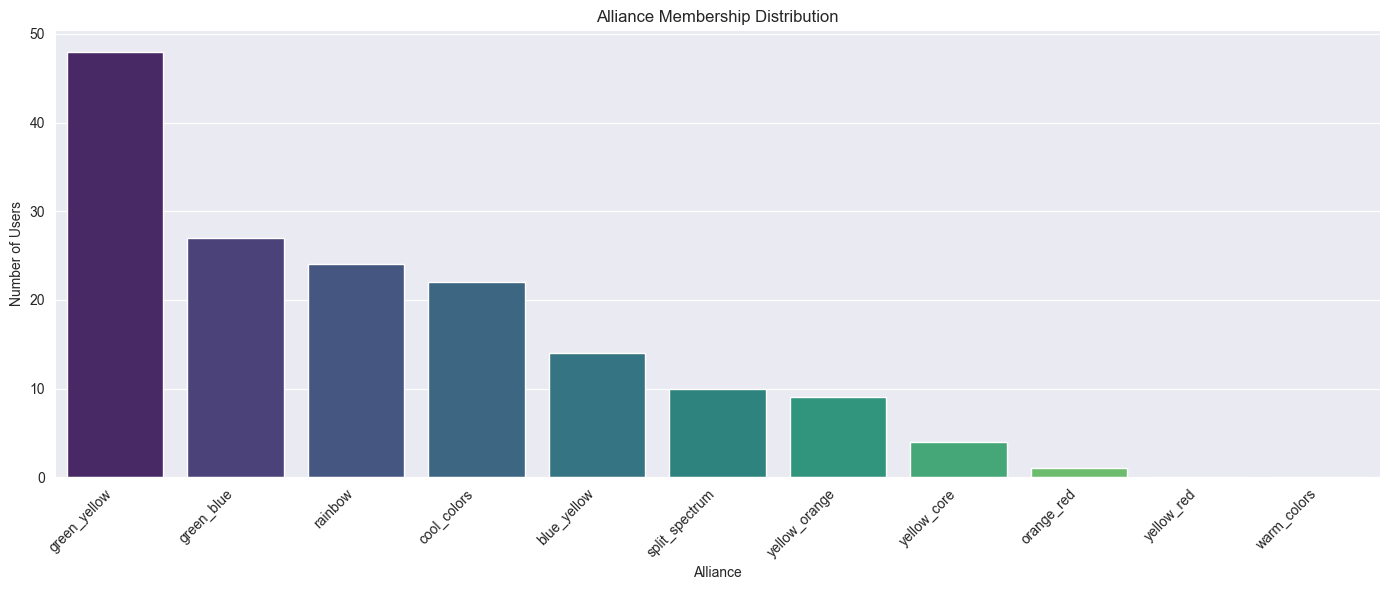

In [27]:
alliance_columns = ['green_blue', 'blue_yellow', 'yellow_core', 'yellow_orange', 'orange_red',
                   'green_yellow', 'yellow_red', 'split_spectrum', 'rainbow', 'cool_colors', 'warm_colors']

alliance_counts = {col: df[col].sum() for col in alliance_columns}
alliance_df = pd.DataFrame(list(alliance_counts.items()), columns=['Alliance', 'Count'])
alliance_df['Percentage'] = (alliance_df['Count'] / len(df) * 100).round(2)
alliance_df = alliance_df.sort_values('Count', ascending=False)

print('Alliance Membership Counts:\n')
print(alliance_df.to_string(index=False))

# Visualize
plt.figure(figsize=(14, 6))
sns.barplot(data=alliance_df, x='Alliance', y='Count', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Alliance Membership Distribution')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

## Statistical Comparison: Green-Blue vs Cool Colors

These two alliances are similar - let's analyze the differences.

Green-Blue members: 27
Cool Colors members: 22
Overlap (both): 22 (81.5% of GB)
Green-Blue only: 5
Cool Colors only: 0

Average scores by group:

Dimension       Green-Blue   Cool Colors  Difference   p-value
------------------------------------------------------------
trade_score            1.26        1.32       -0.06      0.8672
abortion_score         0.78        0.73        0.05      0.8692
migration_score        1.44        1.55       -0.10      0.7297
economics_score        1.44        1.55       -0.10      0.7777
rights_score           0.67        0.64        0.03      0.9198


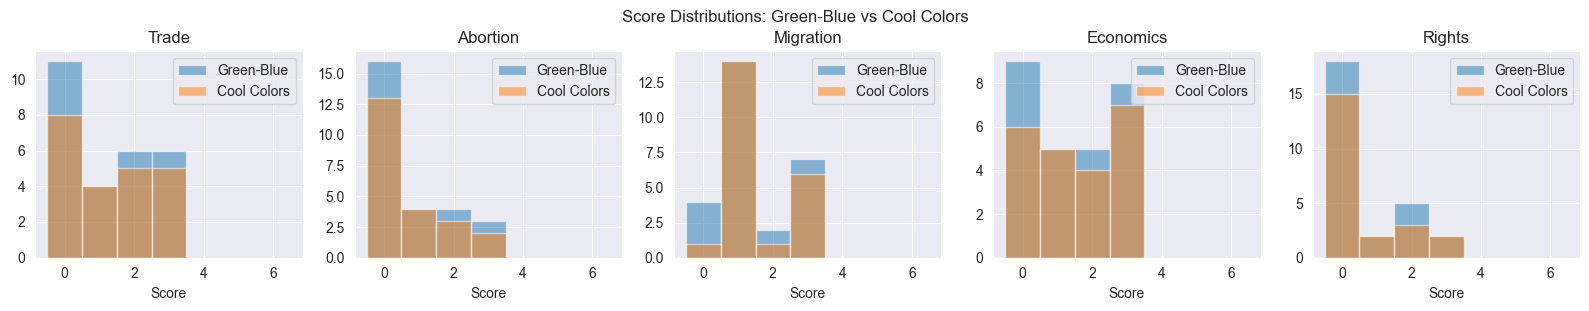

In [28]:
# Compare Green-Blue vs Cool Colors
gb_users = df[df['green_blue']]
cc_users = df[df['cool_colors']]

# Overlap analysis
overlap = df[df['green_blue'] & df['cool_colors']]
gb_only = df[df['green_blue'] & ~df['cool_colors']]
cc_only = df[~df['green_blue'] & df['cool_colors']]

print(f"Green-Blue members: {len(gb_users)}")
print(f"Cool Colors members: {len(cc_users)}")
print(f"Overlap (both): {len(overlap)} ({len(overlap)/len(gb_users)*100:.1f}% of GB)")
print(f"Green-Blue only: {len(gb_only)}")
print(f"Cool Colors only: {len(cc_only)}")
print()

# Statistical comparison of dimension scores
dimensions = ['trade_score', 'abortion_score', 'migration_score', 'economics_score', 'rights_score']
print("Average scores by group:")
print(f"\n{'Dimension':<15} {'Green-Blue':<12} {'Cool Colors':<12} {'Difference':<12} {'p-value'}")
print("-" * 60)

for dim in dimensions:
    gb_mean = gb_users[dim].mean()
    cc_mean = cc_users[dim].mean()
    diff = gb_mean - cc_mean
    
    # T-test
    t_stat, p_val = stats.ttest_ind(gb_users[dim], cc_users[dim])
    
    print(f"{dim:<15} {gb_mean:>11.2f} {cc_mean:>11.2f} {diff:>11.2f} {p_val:>11.4f}")

# Visualize score distributions
fig, axes = plt.subplots(1, 5, figsize=(16, 3))
for idx, dim in enumerate(dimensions):
    axes[idx].hist(gb_users[dim], alpha=0.5, label='Green-Blue', bins=7, range=(-0.5, 6.5))
    axes[idx].hist(cc_users[dim], alpha=0.5, label='Cool Colors', bins=7, range=(-0.5, 6.5))
    axes[idx].set_title(dim.replace('_score', '').title())
    axes[idx].set_xlabel('Score')
    axes[idx].legend()
plt.tight_layout()
plt.suptitle('Score Distributions: Green-Blue vs Cool Colors', y=1.02)
plt.show()

## Alliance Overlap Matrix

How much do different alliances overlap with each other?

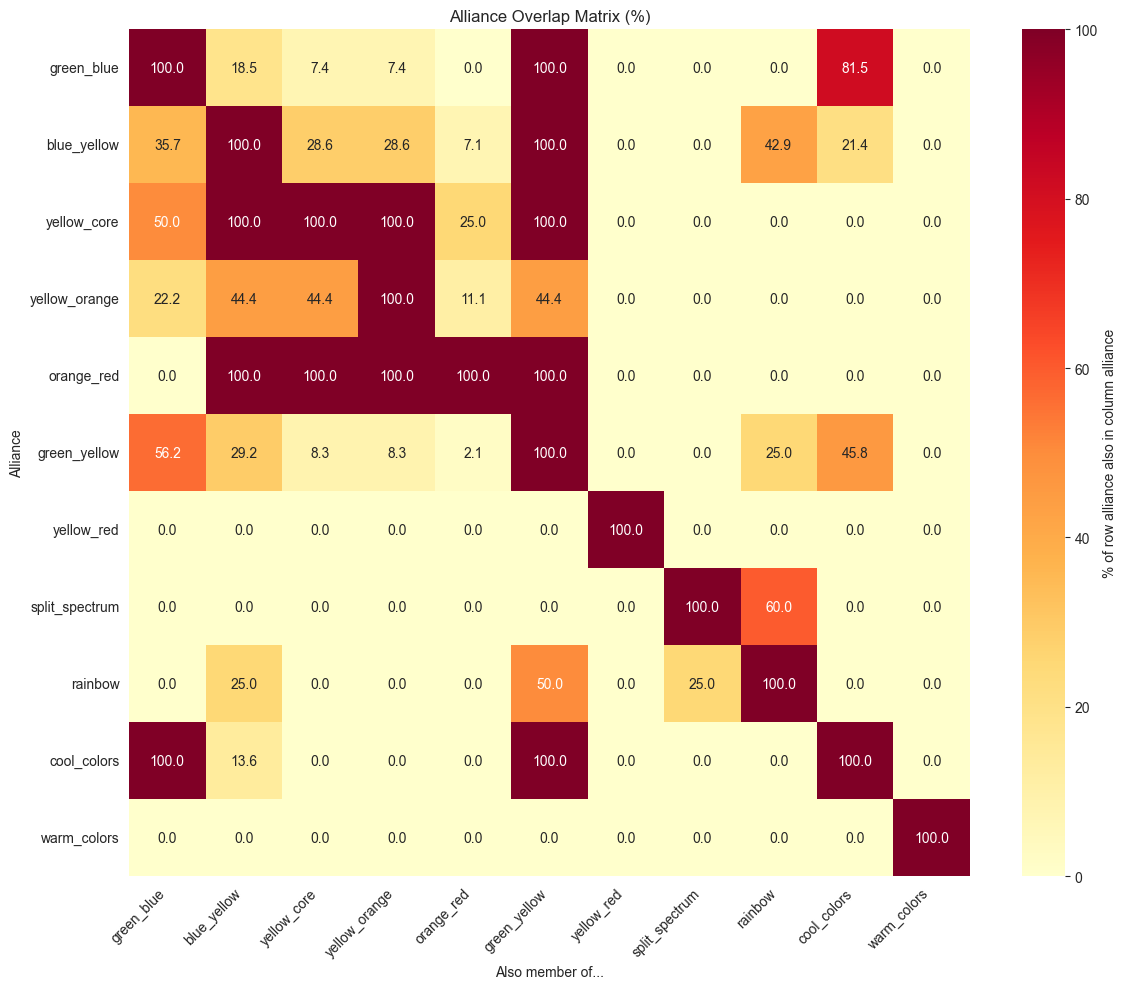


Highest overlaps (excluding self):
green_blue           -> green_yellow         (100.0%)
blue_yellow          -> green_yellow         (100.0%)
yellow_core          -> blue_yellow          (100.0%)
yellow_orange        -> blue_yellow          (44.4%)
orange_red           -> blue_yellow          (100.0%)
green_yellow         -> green_blue           (56.2%)
yellow_red           -> green_blue           (0.0%)
split_spectrum       -> rainbow              (60.0%)
rainbow              -> green_yellow         (50.0%)
cool_colors          -> green_blue           (100.0%)
warm_colors          -> green_blue           (0.0%)


In [29]:
# Create overlap matrix
overlap_matrix = pd.DataFrame(index=alliance_columns, columns=alliance_columns)

for alliance1 in alliance_columns:
    for alliance2 in alliance_columns:
        if alliance1 == alliance2:
            overlap_matrix.loc[alliance1, alliance2] = 100.0
        else:
            both = df[df[alliance1] & df[alliance2]]
            total = len(df[df[alliance1]])  # FIX: Use len() instead of sum()
            if total > 0:
                overlap_pct = len(both) / total * 100
                overlap_matrix.loc[alliance1, alliance2] = overlap_pct
            else:
                overlap_matrix.loc[alliance1, alliance2] = 0

overlap_matrix = overlap_matrix.astype(float)

# Visualize as heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(overlap_matrix, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': '% of row alliance also in column alliance'})
plt.title('Alliance Overlap Matrix (%)')
plt.xlabel('Also member of...')
plt.ylabel('Alliance')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nHighest overlaps (excluding self):")
overlap_copy = overlap_matrix.copy()
for alliance in alliance_columns:
    overlap_copy.loc[alliance, alliance] = 0  # Exclude self
    max_overlap = overlap_copy.loc[alliance].max()
    max_alliance = overlap_copy.loc[alliance].idxmax()
    print(f"{alliance:<20} -> {max_alliance:<20} ({max_overlap:.1f}%)")

In [30]:
# Compare adjacent/similar alliances
comparisons = [
    ('green_blue', 'blue_yellow', 'Green-Blue vs Blue-Yellow'),
    ('blue_yellow', 'yellow_core', 'Blue-Yellow vs Yellow Core'),
    ('yellow_core', 'yellow_orange', 'Yellow Core vs Yellow-Orange'),
    ('yellow_orange', 'orange_red', 'Yellow-Orange vs Orange-Red'),
    ('green_blue', 'cool_colors', 'Green-Blue vs Cool Colors'),
    ('orange_red', 'warm_colors', 'Orange-Red vs Warm Colors'),
]

for alliance1, alliance2, title in comparisons:
    print(f"\n{'='*70}")
    print(f"{title}")
    print('='*70)
    
    group1 = df[df[alliance1]]
    group2 = df[df[alliance2]]
    overlap = df[df[alliance1] & df[alliance2]]
    
    print(f"\n{alliance1}: {len(group1)} members")
    print(f"{alliance2}: {len(group2)} members")
    
    # Handle case where one group has 0 members
    min_size = min(len(group1), len(group2))
    if min_size > 0:
        print(f"Overlap: {len(overlap)} ({len(overlap)/min_size*100:.1f}% of smaller group)")
    else:
        print(f"Overlap: {len(overlap)} (Cannot calculate percentage - one group has 0 members)")
        print("Skipping comparison due to empty group.\n")
        continue
    
    # Key differences
    print(f"\n{'Dimension':<15} {alliance1:<12} {alliance2:<12} {'Diff':<8} {'Sig?'}")
    print("-" * 60)
    
    for dim in dimensions:
        mean1 = group1[dim].mean()
        mean2 = group2[dim].mean()
        diff = mean1 - mean2
        
        # T-test
        if len(group1) > 1 and len(group2) > 1:
            t_stat, p_val = stats.ttest_ind(group1[dim], group2[dim])
            sig = '***' if p_val < 0.01 else '**' if p_val < 0.05 else '*' if p_val < 0.1 else ''
        else:
            sig = ''
        
        print(f"{dim:<15} {mean1:>7.2f}     {mean2:>7.2f}   {diff:>6.2f}   {sig:>4}")
    
    # Non-overlapping members
    only_1 = df[df[alliance1] & ~df[alliance2]]
    only_2 = df[df[alliance2] & ~df[alliance1]]
    
    print(f"\nOnly in {alliance1}: {len(only_1)}")
    print(f"Only in {alliance2}: {len(only_2)}")
    
    if len(only_1) > 0:
        print(f"  {alliance1}-only avg scores: T={only_1['trade_score'].mean():.1f}, A={only_1['abortion_score'].mean():.1f}, M={only_1['migration_score'].mean():.1f}, E={only_1['economics_score'].mean():.1f}, R={only_1['rights_score'].mean():.1f}")
    if len(only_2) > 0:
        print(f"  {alliance2}-only avg scores: T={only_2['trade_score'].mean():.1f}, A={only_2['abortion_score'].mean():.1f}, M={only_2['migration_score'].mean():.1f}, E={only_2['economics_score'].mean():.1f}, R={only_2['rights_score'].mean():.1f}")


Green-Blue vs Blue-Yellow

green_blue: 27 members
blue_yellow: 14 members
Overlap: 5 (35.7% of smaller group)

Dimension       green_blue   blue_yellow  Diff     Sig?
------------------------------------------------------------
trade_score        1.26        2.21    -0.96     **
abortion_score     0.78        2.43    -1.65    ***
migration_score    1.44        2.29    -0.84     **
economics_score    1.44        2.64    -1.20    ***
rights_score       0.67        2.21    -1.55    ***

Only in green_blue: 22
Only in blue_yellow: 9
  green_blue-only avg scores: T=1.1, A=0.5, M=1.3, E=1.3, R=0.4
  blue_yellow-only avg scores: T=2.4, A=2.8, M=2.4, E=2.9, R=2.3

Blue-Yellow vs Yellow Core

blue_yellow: 14 members
yellow_core: 4 members
Overlap: 4 (100.0% of smaller group)

Dimension       blue_yellow  yellow_core  Diff     Sig?
------------------------------------------------------------
trade_score        2.21        3.25    -1.04       
abortion_score     2.43        3.00    -0.57       


Alliance Statistics:
      Alliance  Count  Avg Divergence  Avg Spread
split_spectrum     10        2.168245    2.088080
   cool_colors     22        2.135399    0.974900
    green_blue     27        2.130666    0.830652
  green_yellow     48        1.870063    1.032805
       rainbow     24        1.742286    1.599736
   blue_yellow     14        1.183029    0.865730
 yellow_orange      9        1.019150    0.895523
   yellow_core      4        0.739061    0.554506
    orange_red      1        0.632456    0.489898



/var/folders/5r/r8zyq_hd3mnf80rnkmjttmh80000gn/T/ipykernel_36278/3126318909.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=stats_df, x='Alliance', y='Avg Divergence', palette='coolwarm', ax=ax1)
/var/folders/5r/r8zyq_hd3mnf80rnkmjttmh80000gn/T/ipykernel_36278/3126318909.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
/var/folders/5r/r8zyq_hd3mnf80rnkmjttmh80000gn/T/ipykernel_36278/3126318909.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=stats_df.sort_values('Avg Spread', ascending=False),
/var/folders/5r/r8zyq_hd

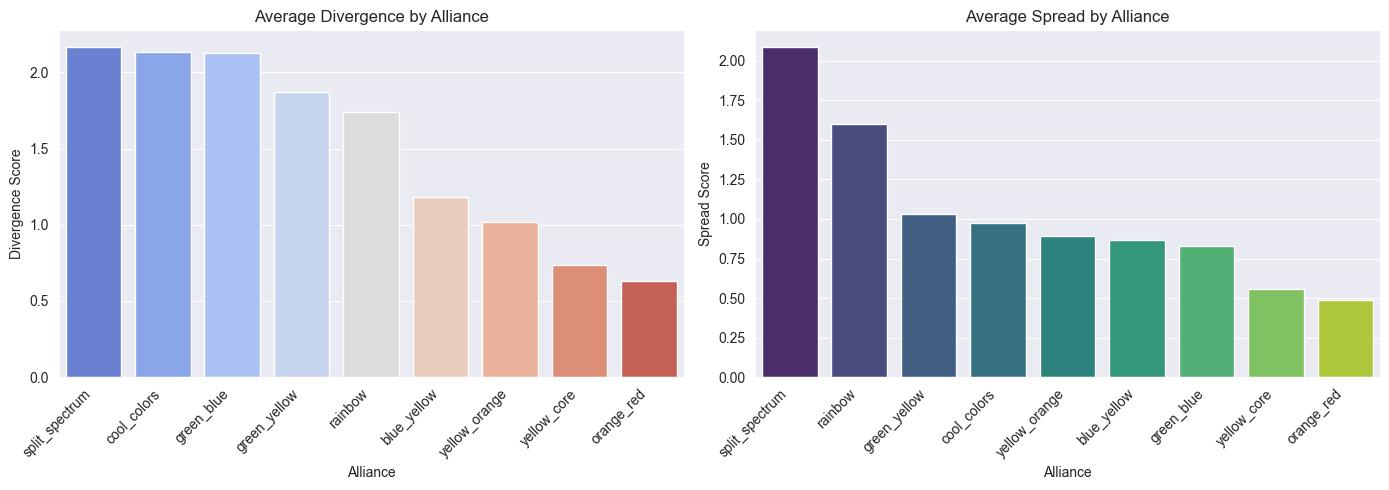

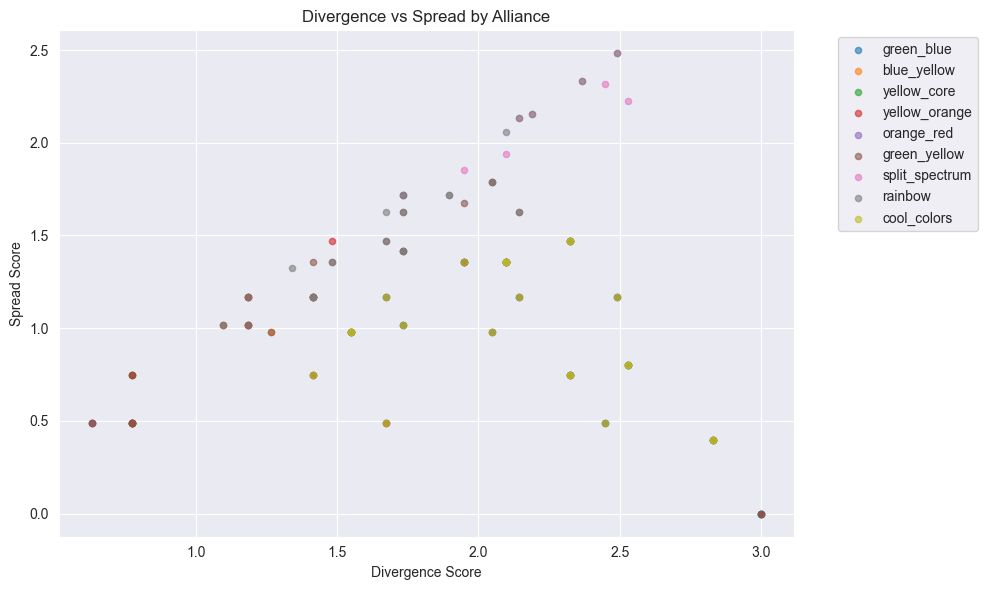

In [31]:
# Calculate average divergence and spread for each alliance
alliance_stats = []

for alliance in alliance_columns:
    alliance_members = df[df[alliance]]
    if len(alliance_members) > 0:
        avg_divergence = alliance_members['divergence_score'].mean()
        avg_spread = alliance_members['spread_score'].mean()
        alliance_stats.append({
            'Alliance': alliance,
            'Count': len(alliance_members),
            'Avg Divergence': avg_divergence,
            'Avg Spread': avg_spread
        })

stats_df = pd.DataFrame(alliance_stats).sort_values('Avg Divergence', ascending=False)
print("Alliance Statistics:")
print(stats_df.to_string(index=False))
print()

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Divergence
sns.barplot(data=stats_df, x='Alliance', y='Avg Divergence', palette='coolwarm', ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_title('Average Divergence by Alliance')
ax1.set_ylabel('Divergence Score')

# Spread
sns.barplot(data=stats_df.sort_values('Avg Spread', ascending=False), 
            x='Alliance', y='Avg Spread', palette='viridis', ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_title('Average Spread by Alliance')
ax2.set_ylabel('Spread Score')

plt.tight_layout()
plt.show()

# Scatter plot: Divergence vs Spread by alliance
plt.figure(figsize=(10, 6))
for alliance in alliance_columns:
    alliance_members = df[df[alliance]]
    if len(alliance_members) > 0:
        plt.scatter(alliance_members['divergence_score'], 
                   alliance_members['spread_score'],
                   alpha=0.6, label=alliance, s=20)
plt.xlabel('Divergence Score')
plt.ylabel('Spread Score')
plt.title('Divergence vs Spread by Alliance')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Dimension-Specific Analysis

Which dimensions vary most within each alliance?

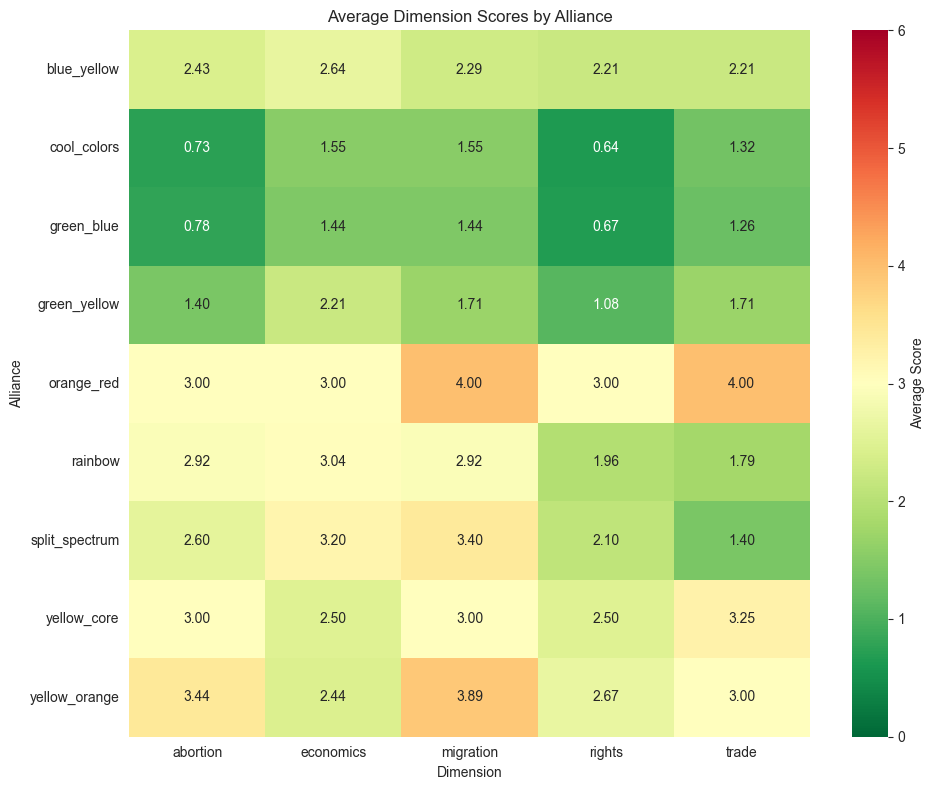

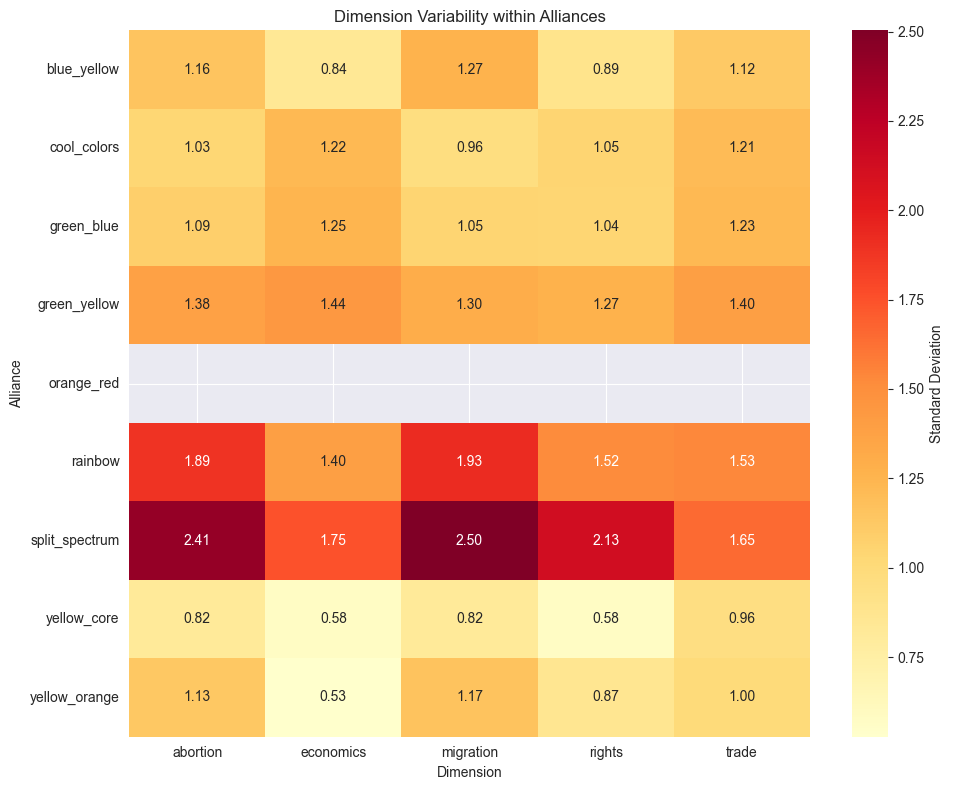

Most variable dimensions by alliance (highest std dev):
green_blue           -> economics       (σ=1.25)
blue_yellow          -> migration       (σ=1.27)
yellow_core          -> trade           (σ=0.96)
yellow_orange        -> migration       (σ=1.17)
orange_red           -> trade           (σ=nan)
green_yellow         -> economics       (σ=1.44)
split_spectrum       -> migration       (σ=2.50)
rainbow              -> migration       (σ=1.93)
cool_colors          -> economics       (σ=1.22)


In [32]:
# Calculate mean and std for each dimension within each alliance
dimension_analysis = []

for alliance in alliance_columns:
    alliance_members = df[df[alliance]]
    if len(alliance_members) > 0:
        for dim in dimensions:
            dimension_analysis.append({
                'Alliance': alliance,
                'Dimension': dim.replace('_score', ''),
                'Mean': alliance_members[dim].mean(),
                'Std': alliance_members[dim].std(),
                'Min': alliance_members[dim].min(),
                'Max': alliance_members[dim].max()
            })

dim_df = pd.DataFrame(dimension_analysis)

# Heatmap of mean scores
pivot_mean = dim_df.pivot(index='Alliance', columns='Dimension', values='Mean')
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_mean, annot=True, fmt='.2f', cmap='RdYlGn_r', center=3, 
            vmin=0, vmax=6, cbar_kws={'label': 'Average Score'})
plt.title('Average Dimension Scores by Alliance')
plt.tight_layout()
plt.show()

# Heatmap of standard deviations (shows which dimensions vary most)
pivot_std = dim_df.pivot(index='Alliance', columns='Dimension', values='Std')
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_std, annot=True, fmt='.2f', cmap='YlOrRd', 
            cbar_kws={'label': 'Standard Deviation'})
plt.title('Dimension Variability within Alliances')
plt.tight_layout()
plt.show()

print("Most variable dimensions by alliance (highest std dev):")
for alliance in alliance_columns:
    alliance_data = dim_df[dim_df['Alliance'] == alliance].sort_values('Std', ascending=False)
    if len(alliance_data) > 0:
        top_var = alliance_data.iloc[0]
        print(f"{alliance:<20} -> {top_var['Dimension']:<15} (σ={top_var['Std']:.2f})")

## Example Profiles by Alliance

Show representative users from each alliance.

In [33]:
# Show example profiles (users closest to the alliance mean)
print("Representative users from each alliance (closest to mean):\n")

for alliance in alliance_columns:
    alliance_members = df[df[alliance]]
    if len(alliance_members) > 0:
        # Calculate mean scores for this alliance
        mean_scores = alliance_members[dimensions].mean()
        
        # Find user closest to mean (minimum distance)
        alliance_members_copy = alliance_members.copy()
        alliance_members_copy['distance'] = alliance_members_copy[dimensions].apply(
            lambda row: np.sqrt(sum((row[dim] - mean_scores[dim])**2 for dim in dimensions)),
            axis=1
        )
        closest_user = alliance_members_copy.nsmallest(1, 'distance').iloc[0]
        
        print(f"{alliance.upper()}")
        print(f"  User: @{closest_user['username']} (FID: {closest_user['fid']})")
        print(f"  Scores: T={closest_user['trade_score']}, A={closest_user['abortion_score']}, " +
              f"M={closest_user['migration_score']}, E={closest_user['economics_score']}, R={closest_user['rights_score']}")
        print(f"  Divergence: {closest_user['divergence_score']:.2f}, Spread: {closest_user['spread_score']:.2f}")
        print()

Representative users from each alliance (closest to mean):

GREEN_BLUE
  User: @jonathancolton (FID: 296687)
  Scores: T=1, A=0, M=1, E=1, R=0
  Divergence: 2.45, Spread: 0.49

BLUE_YELLOW
  User: @kidmyr.eth (FID: 561399)
  Scores: T=2, A=3, M=2, E=3, R=2
  Divergence: 0.77, Spread: 0.49

YELLOW_CORE
  User: @cryptim.eth (FID: 466688)
  Scores: T=3, A=2, M=3, E=2, R=2
  Divergence: 0.77, Spread: 0.49

YELLOW_ORANGE
  User: @eatzebugs (FID: 325644)
  Scores: T=4, A=3, M=4, E=3, R=3
  Divergence: 0.63, Spread: 0.49

ORANGE_RED
  User: @eatzebugs (FID: 325644)
  Scores: T=4, A=3, M=4, E=3, R=3
  Divergence: 0.63, Spread: 0.49

GREEN_YELLOW
  User: @seanhart (FID: 4612)
  Scores: T=1, A=2, M=1, E=2, R=1
  Divergence: 1.67, Spread: 0.49

SPLIT_SPECTRUM
  User: @leadgen (FID: 1007423)
  Scores: T=0, A=4, M=5, E=3, R=2
  Divergence: 1.73, Spread: 1.72

RAINBOW
  User: @mustang (FID: 213559)
  Scores: T=1, A=3, M=3, E=4, R=2
  Divergence: 1.10, Spread: 1.02

COOL_COLORS
  User: @jonathancolto

## Adjacent Alliance Comparisons

Deep dive into differences between similar alliances.

In [34]:
# Compare adjacent/similar alliances
comparisons = [
    ('green_blue', 'blue_yellow', 'Green-Blue vs Blue-Yellow'),
    ('blue_yellow', 'yellow_core', 'Blue-Yellow vs Yellow Core'),
    ('yellow_core', 'yellow_orange', 'Yellow Core vs Yellow-Orange'),
    ('yellow_orange', 'orange_red', 'Yellow-Orange vs Orange-Red'),
    ('green_blue', 'cool_colors', 'Green-Blue vs Cool Colors'),
    ('orange_red', 'warm_colors', 'Orange-Red vs Warm Colors'),
]

for alliance1, alliance2, title in comparisons:
    print(f"\n{'='*70}")
    print(f"{title}")
    print('='*70)
    
    group1 = df[df[alliance1]]
    group2 = df[df[alliance2]]
    overlap = df[df[alliance1] & df[alliance2]]
    
    print(f"\n{alliance1}: {len(group1)} members")
    print(f"{alliance2}: {len(group2)} members")
    
    # Handle case where one group has 0 members
    min_size = min(len(group1), len(group2))
    if min_size > 0:
        print(f"Overlap: {len(overlap)} ({len(overlap)/min_size*100:.1f}% of smaller group)")
    else:
        print(f"Overlap: {len(overlap)} (Cannot calculate percentage - one group has 0 members)")
        print("Skipping comparison due to empty group.\n")
        continue
    
    # Key differences
    print(f"\n{'Dimension':<15} {alliance1:<12} {alliance2:<12} {'Diff':<8} {'Sig?'}")
    print("-" * 60)
    
    for dim in dimensions:
        mean1 = group1[dim].mean()
        mean2 = group2[dim].mean()
        diff = mean1 - mean2
        
        # T-test
        if len(group1) > 1 and len(group2) > 1:
            t_stat, p_val = stats.ttest_ind(group1[dim], group2[dim])
            sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
        else:
            sig = ""
        
        print(f"{dim:<15} {mean1:>11.2f} {mean2:>11.2f} {diff:>7.2f} {sig:>5}")
    
    # Who's in one but not the other?
    only1 = df[df[alliance1] & ~df[alliance2]]
    only2 = df[~df[alliance1] & df[alliance2]]
    
    print(f"\nOnly in {alliance1}: {len(only1)}")
    print(f"Only in {alliance2}: {len(only2)}")
    
    if len(only1) > 0:
        print(f"  {alliance1}-only avg scores: ", end="")
        print(", ".join([f"{dim.split('_')[0][0].upper()}={only1[dim].mean():.1f}" for dim in dimensions]))
    
    if len(only2) > 0:
        print(f"  {alliance2}-only avg scores: ", end="")
        print(", ".join([f"{dim.split('_')[0][0].upper()}={only2[dim].mean():.1f}" for dim in dimensions]))


Green-Blue vs Blue-Yellow

green_blue: 27 members
blue_yellow: 14 members
Overlap: 5 (35.7% of smaller group)

Dimension       green_blue   blue_yellow  Diff     Sig?
------------------------------------------------------------
trade_score            1.26        2.21   -0.96     *
abortion_score         0.78        2.43   -1.65   ***
migration_score        1.44        2.29   -0.84     *
economics_score        1.44        2.64   -1.20    **
rights_score           0.67        2.21   -1.55   ***

Only in green_blue: 22
Only in blue_yellow: 9
  green_blue-only avg scores: T=1.1, A=0.5, M=1.3, E=1.3, R=0.4
  blue_yellow-only avg scores: T=2.4, A=2.8, M=2.4, E=2.9, R=2.3

Blue-Yellow vs Yellow Core

blue_yellow: 14 members
yellow_core: 4 members
Overlap: 4 (100.0% of smaller group)

Dimension       blue_yellow  yellow_core  Diff     Sig?
------------------------------------------------------------
trade_score            2.21        3.25   -1.04      
abortion_score         2.43        3.00 

## Alliance Exclusivity

Which alliances are most exclusive (least overlap with others)?

Distribution of alliance memberships:
alliance_count
0     8
1    21
2    16
3    25
4     4
5     3
Name: count, dtype: int64

Alliance Exclusivity (% of members who belong ONLY to this alliance):
      Alliance  Members  Avg Memberships  % Exclusive
 yellow_orange        9         2.666667    55.555556
split_spectrum       10         1.600000    40.000000
       rainbow       24         2.000000    25.000000
  green_yellow       48         2.750000    12.500000
    green_blue       27         3.148148     0.000000
   blue_yellow       14         3.642857     0.000000
   yellow_core        4         4.750000     0.000000
    orange_red        1         5.000000     0.000000
   cool_colors       22         3.136364     0.000000



/var/folders/5r/r8zyq_hd3mnf80rnkmjttmh80000gn/T/ipykernel_36278/427329454.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=excl_df, x='Alliance', y='% Exclusive', palette='rocket', ax=ax1)
/var/folders/5r/r8zyq_hd3mnf80rnkmjttmh80000gn/T/ipykernel_36278/427329454.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
/var/folders/5r/r8zyq_hd3mnf80rnkmjttmh80000gn/T/ipykernel_36278/427329454.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=excl_df.sort_values('Avg Memberships'),
/var/folders/5r/r8zyq_hd3mnf80rnkmjttmh80000gn

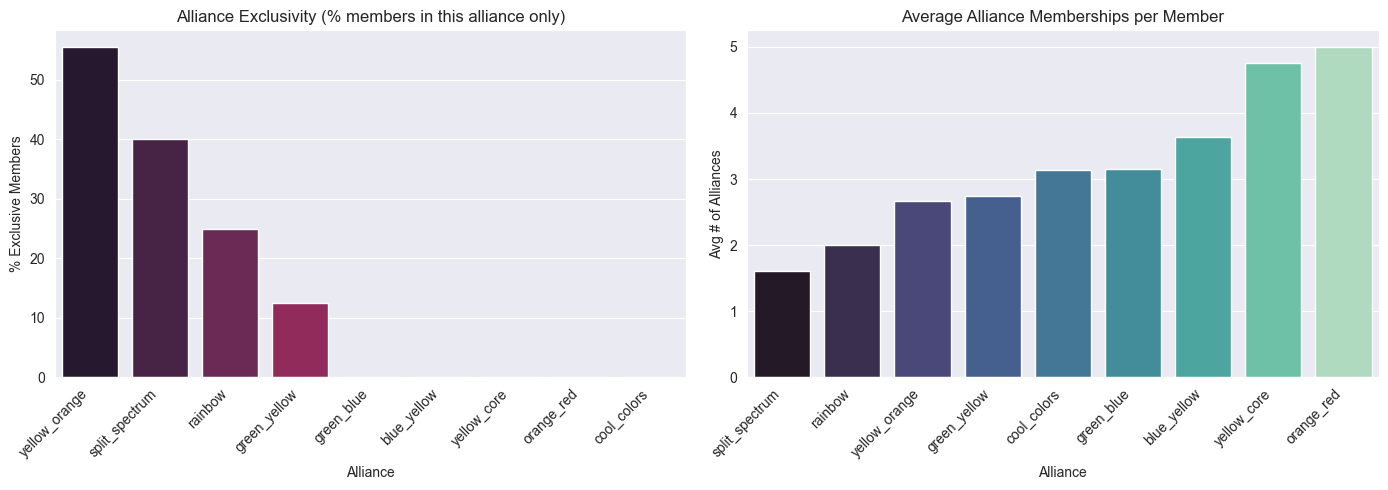


Users with most alliance memberships:
   username     fid  alliance_count  trade_score  abortion_score  migration_score  economics_score  rights_score
 kidmyr.eth  561399               5            2               3                2                3             2
cryptim.eth  466688               5            3               2                3                2             2
  eatzebugs  325644               5            4               3                4                3             3
 insanelabz 1007471               4            1               1                3                1             3
   dogmatik  309256               4            4               4                3                2             3
     ajrony  291302               4            2               1                1                3             2
   seanhart    4612               4            1               2                1                2             1
hiponax.eth  410486               3            3         

In [35]:
# Calculate how many alliances each user belongs to
df['alliance_count'] = df[alliance_columns].sum(axis=1)

print("Distribution of alliance memberships:")
print(df['alliance_count'].value_counts().sort_index())
print()

# Calculate exclusivity score for each alliance
exclusivity = []
for alliance in alliance_columns:
    alliance_members = df[df[alliance]]
    if len(alliance_members) > 0:
        avg_memberships = alliance_members['alliance_count'].mean()
        pct_exclusive = (alliance_members['alliance_count'] == 1).sum() / len(alliance_members) * 100
        exclusivity.append({
            'Alliance': alliance,
            'Members': len(alliance_members),
            'Avg Memberships': avg_memberships,
            '% Exclusive': pct_exclusive
        })

excl_df = pd.DataFrame(exclusivity).sort_values('% Exclusive', ascending=False)
print("Alliance Exclusivity (% of members who belong ONLY to this alliance):")
print(excl_df.to_string(index=False))
print()

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=excl_df, x='Alliance', y='% Exclusive', palette='rocket', ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_title('Alliance Exclusivity (% members in this alliance only)')
ax1.set_ylabel('% Exclusive Members')

sns.barplot(data=excl_df.sort_values('Avg Memberships'), 
            x='Alliance', y='Avg Memberships', palette='mako', ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_title('Average Alliance Memberships per Member')
ax2.set_ylabel('Avg # of Alliances')

plt.tight_layout()
plt.show()

# Show users who belong to many alliances
print("\nUsers with most alliance memberships:")
top_members = df.nlargest(10, 'alliance_count')[['username', 'fid', 'alliance_count'] + dimensions]
print(top_members.to_string(index=False))